In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.nn import functional as F
from torch.nn import Sequential, Tanh, Parameter
import mlflow as mlflow
%matplotlib inline

In [11]:
torch.backends.mps.is_available()

True

In [12]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [13]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [14]:
len(vocab)

27

In [15]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [16]:
torch.set_default_device("cpu")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)
n_context = 8
train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182500, 8]) torch.Size([182500])
torch.Size([22847, 8]) torch.Size([22847])
torch.Size([22799, 8]) torch.Size([22799])


In [17]:
Xtr

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0, 10],
        [ 0,  0,  0,  ...,  0, 10,  1],
        ...,
        [ 0,  0,  0,  ..., 15, 16, 16],
        [ 0,  0,  0,  ..., 16, 16,  9],
        [ 0,  0, 16,  ..., 16,  9,  5]])

In [18]:
e_dim = 10
h_dim = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(vocab), e_dim, generator=g) # character embeddings with dimension of e_dim
W1 = torch.randn(n_context*e_dim, h_dim, generator=g) #* (5/3) /((e_dim * n_context)**0.5) # kammit init
b1 = torch.randn(h_dim, generator=g) * 0.01
W2 = torch.randn(h_dim,len(vocab), generator=g) * 0.01
b2 = torch.randn(len(vocab), generator=g) * 0

#Batch Norm pparameters
bgain = torch.ones((1,h_dim))
bbias = torch.zeros((1,h_dim))
bmeanrunning = torch.zeros((1,h_dim))
bstdrunning = torch.ones((1,h_dim))
alpha = 0.999
eps = 1e-5

parameters = [C,W1,b1,W2,b2,bgain,bbias]

In [667]:
lrs = torch.linspace(-3,1,20)
loglrs = 10**lrs

In [668]:
lossi = []
rsloss = []

In [669]:
sum( p.nelement() for p in parameters)

22297

In [670]:
for p in parameters:
    p.requires_grad = True

In [671]:

t = time.time()
batch_size = 32
lrsloss = []
for i in range(200000):
    #forward pass
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtr[ix]]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    bmeani = preh.mean(0,keepdim=True)
    bstdi = preh.std(0,keepdim = True)
    preh = bgain*(preh - bmeani)/ (bstdi + eps) + bbias
    with torch.no_grad():
        bmeanrunning = alpha * bmeanrunning + (1 - alpha)* bmeani
        bstdrunning = alpha * bstdrunning + (1 - alpha) * bstdi
        
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ytr[ix])
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    for p in parameters:
        p.grad = None 
    #backpass
    loss.backward()
    
    #update
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(F"Mins taken: {(t - time.time())/60}")
print(F" Final loss: {loss.item():.4f}")


loss at 0/200000 3.2863
loss at 10000/200000 2.5512
loss at 20000/200000 2.1200
loss at 30000/200000 2.2302
loss at 40000/200000 2.2285
loss at 50000/200000 2.4509
loss at 60000/200000 2.3184
loss at 70000/200000 2.1552
loss at 80000/200000 2.2173
loss at 90000/200000 2.3069
loss at 100000/200000 2.1754
loss at 110000/200000 2.3012
loss at 120000/200000 2.2273
loss at 130000/200000 1.8041
loss at 140000/200000 1.8234
loss at 150000/200000 2.0544
loss at 160000/200000 2.3530
loss at 170000/200000 2.3585
loss at 180000/200000 1.7719
loss at 190000/200000 2.1113
Mins taken: -1.8146247347195943
 Final loss: 2.2918


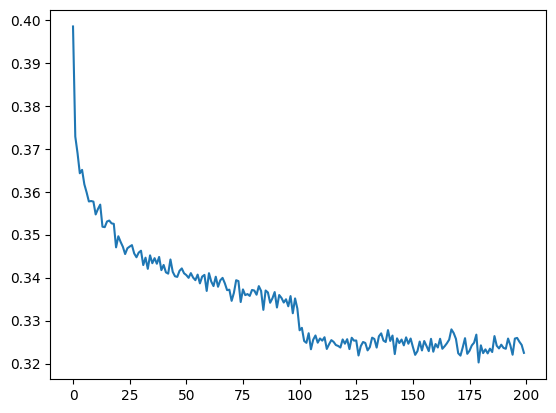

In [672]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

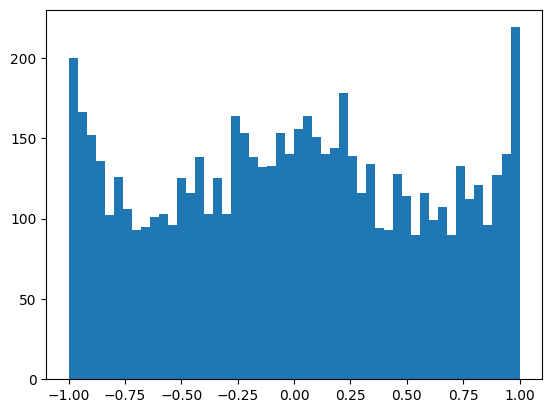

In [673]:
plt.hist(h.view(-1).data,bins=50)
plt.show()

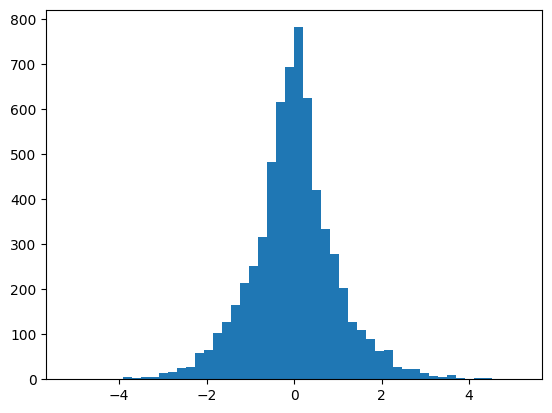

In [674]:
plt.hist(preh.view(-1).data,bins=50)
plt.show()

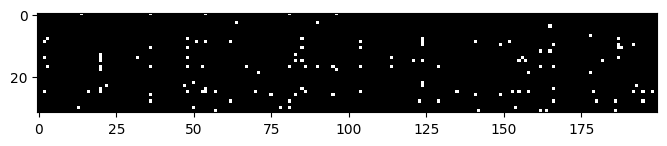

In [675]:
plt.figure(figsize=(8,8))
plt.imshow(h.abs() > .99,cmap="grey",interpolation="nearest");

In [135]:
with torch.no_grad():
    emb = C[Xtr]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    bmean = preh.mean(0,keepdim=True)
    bstd = preh.std(0,keepdim = True)
    

In [136]:
bmean

tensor([[-4.0804e+00,  4.1977e-01, -4.6892e+00,  2.5287e+00,  2.9221e+00,
          1.9070e+00,  5.6661e+00, -4.3624e+00,  9.1693e-01,  3.4727e+00,
         -4.8335e+00, -5.7923e+00, -1.0815e+00, -1.2692e+00, -2.6707e-01,
          1.5299e+00,  2.1963e+00, -5.4819e+00, -2.9082e+00,  3.3509e+00,
          9.0327e-01, -3.3229e+00, -1.7457e+00,  2.6683e+00,  2.3498e+00,
          2.2184e+00,  1.6561e+00, -7.7108e-01,  5.7945e-03,  3.0946e+00,
         -1.1574e+00, -3.4161e+00,  7.5633e-01,  1.1627e+00, -1.2786e+00,
         -3.5290e+00, -1.0892e+00, -2.0435e+00, -1.1587e+00,  1.9304e+00,
          3.3249e-01, -3.6693e+00, -3.7043e+00, -2.6441e-01,  2.6417e+00,
         -7.4664e-01,  8.1036e-01, -3.4601e+00,  3.9051e+00,  4.8033e+00,
          2.5449e+00,  2.3689e+00,  5.5921e+00,  5.2487e+00,  3.1920e+00,
         -4.4182e+00, -7.5544e-01,  2.6648e+00,  5.0518e+00, -2.9564e+00,
         -1.4685e+00,  2.3872e+00,  1.4084e+00, -4.5078e-01,  4.5137e+00,
          1.9941e+00,  2.1586e+00,  1.

In [137]:
bmeanrunning

tensor([[-4.0453,  0.4373, -4.7051,  2.5236,  2.9246,  1.9079,  5.6761, -4.3521,
          0.9891,  3.4835, -4.8388, -5.7726, -1.1002, -1.2218, -0.2717,  1.5563,
          2.2539, -5.4826, -2.8940,  3.3739,  0.8913, -3.3003, -1.7345,  2.6470,
          2.3274,  2.2323,  1.6442, -0.7554,  0.0174,  3.0964, -1.1567, -3.4478,
          0.7707,  1.1625, -1.2413, -3.4878, -1.0728, -2.0125, -1.1539,  1.9484,
          0.3582, -3.6592, -3.6776, -0.2529,  2.6668, -0.7494,  0.7889, -3.4426,
          3.9277,  4.7465,  2.5516,  2.4050,  5.5830,  5.2274,  3.1729, -4.4687,
         -0.7371,  2.6341,  5.0069, -2.9441, -1.4949,  2.3751,  1.3756, -0.4494,
          4.5013,  2.0350,  2.1552,  1.3730, -0.9551, -0.8015,  0.6551,  3.7245,
          2.9639, -3.7763, -5.6703, -0.2242,  4.6218, -0.5616,  1.8264,  0.0111,
          3.2102,  5.6674,  3.4874,  3.2643,  1.0560, -1.5414, -5.4417, -0.2981,
          6.0382, -1.5969, -1.7594,  2.1212, -0.5316, -0.3180, -0.5290, -0.9044,
         -2.6245, -1.4546, -

In [676]:
#dev validation
with torch.no_grad():
    # ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xdev]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    preh = bgain*(preh - bmeanrunning)/ bstdrunning + bbias
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ydev)
    print(loss)

tensor(2.1128)


In [677]:
# test validation 
with torch.no_grad():
    # ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtest]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    preh = bgain*(preh - bmeanrunning)/ bstdrunning + bbias
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ytest)
    print(loss)

tensor(2.1093)


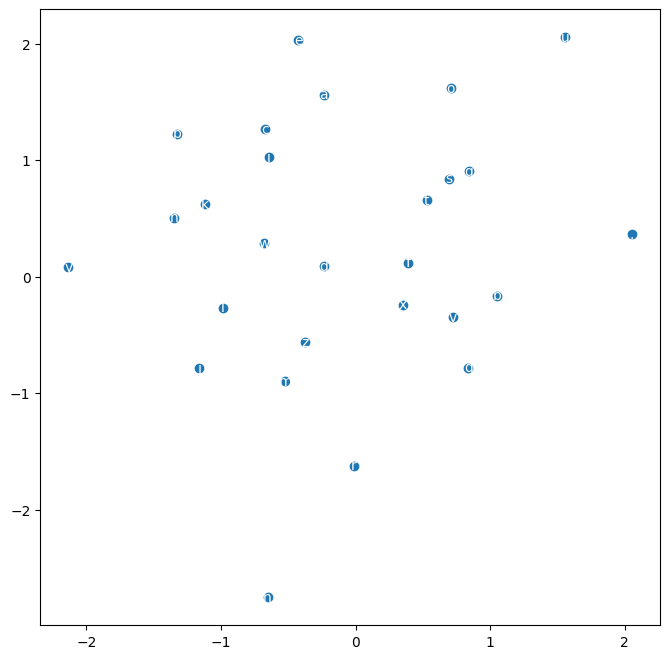

In [678]:
plt.figure(figsize=(8,8))
i=0
C1 = C.cpu().detach().numpy()
plt.scatter(C1[:,0],C1[:,1])
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [679]:


g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    #forward pass
    out = []
    context = [0] * n_context
    while True:
        emb = C[context]
        preh = emb.view(1,-1) @ W1 + b1
        preh = bgain*(preh - bmeanrunning)/ bstdrunning + bbias
        h =  torch.tanh(preh)
        logits= h @ W2 + b2
        p = F.softmax(logits,dim=1)
        ix = torch.multinomial(p,num_samples = 1, replacement = True,generator = g)
        context = context[1:] + [ix.item()]
        if ix.item() == 0:
            break
        out.append(itos[ix.item()])
    print("".join(out))

cexzer
jallee
rochita
kerlin
janain
lucan
kaida
samiyah
jashi
gotai


### Loss log
without any optimization

embedding dimension 2

train loss 1.90

dev loss 2.30

embedding dimension 10

train loss 1.95

dev loss 2.12

kamming init

train loss 2.2

dev loss 2.10


batch norm9

train loss 1.99
dev loss 2.10

In [31]:
class Linear(torch.nn.Module):
    def __init__(self,nin,nout,bias=True):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.W1 = Parameter(torch.randn(nin, nout))
        self.b1 = Parameter(torch.randn(nout)) if bias else None

    
    def forward(self,x):
        self.out = x @ self.W1 * self.nin**-0.5
        if self.b1 != None:
            self.out = self.out + self.b1
        return self.out

    # def parameters(self):
    #     self.parameters = [self.W1] + [self.b1] if self.b1!=None else [self.W1]
    #     return self.parameters 
        
class Flatten(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        if len(x.shape) > 2:
            self.out = x.view(x.shape[0],-1)
        else:
            self.out = x.view(-1,x.shape[0]*x.shape[1])
        return self.out
        
class Embedding(torch.nn.Module):
    def __init__(self,vocab_size,edim):
        super().__init__()
        self.embedding = Parameter(torch.randn(vocab_size, edim))

    def forward(self,x):
        self.out = self.embedding[x]
        return self.out

    # def parameters(self):
    #     self.parameters = [self.embedding]
    #     return self.parameters

class BatchNorm1d(torch.nn.Module):
    def __init__(self,nout,alpha=0.001,eps=1e-05):
        super().__init__()
        self.nout = nout
        self.bgain = Parameter(torch.ones(1,nout))
        self.bbias = Parameter(torch.zeros(1,nout))
        self.bstdrunning = torch.ones(1,nout)
        self.bmeanrunning = torch.zeros(1,nout)
        self.alpha = alpha
        self.eps = eps
        
    def forward(self,x):
        if(self.training):
            bmeani = x.mean(0,keepdim=True)
            bstdi = x.std(0,keepdim = True)
            self.out = self.bgain*(x - bmeani)/ (bstdi + self.eps) + self.bbias
            with torch.no_grad():
                self.bmeanrunning = self.alpha * self.bmeanrunning + (1 - self.alpha)* bmeani
                self.bstdrunning = self.alpha * bstdrunning + (1 - self.alpha) * bstdi
        else:
            self.out = self.bgain*(x - self.bmeanrunning)/ (self.bstdrunning + self.eps) + self.bbias

        return self.out
   
    # def parameters(self):
    #     self.parameters = [self.bgain,self.bbias]
    #     return self.parameters
class RNN(torch.nn.Module):
    def __init__(self,nin,nout):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.h = None
        self.wh = Parameter(torch.randn(nin,nout)) #200 X 200
        self.wx = Parameter(torch.randn(nin,nout))
        self.wy = Parameter(torch.randn(nin,nout))
    
    def forward(self,x):
        if self.h is None:
            self.h = torch.zeros(1,self.nout) # 1x200
        # print(self.h.shape,self.wy.shape,self.wh.shape,self.wx.shape,x.shape)
        self.h = F.tanh((self.h @ self.wh.T) + (x @ self.wx)) #32x200 @ 200 X 200
        out = self.h @ self.wy.T
        print(out.shape)
        return out
    
class Tanh1(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        self.out = F.tanh(x)
        return self.out
@torch.no_grad()
def evaluate(X,Y,model):
    model.eval()
    out = model(X)
    loss = F.cross_entropy(out,Y)
    return out,loss

@torch.no_grad()
def generate(n_words,model):
    model.eval()
    for i in range(10):
        #forward pass
        out = []
        context = [0] * n_context
        while True:
            logits= model([context])
            p = F.softmax(logits,dim=1)
            ix = torch.multinomial(p,num_samples = 1, replacement = True,generator = g)
            context = context[1:] + [ix.item()]
            if ix.item() == 0:
                break
            out.append(itos[ix.item()])
        print("".join(out))


In [32]:
Model =  Sequential(
    Embedding(len(vocab),e_dim),
    Flatten(),
    RNN(n_context*e_dim,h_dim),BatchNorm1d(h_dim),Tanh1(),
    # Linear(h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    # Linear(h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    Linear(h_dim,len(vocab),False)
    
)

In [33]:
batch_size = 32
lrsloss = []

for i in range(200000):
    #forward pass
    lr = 0.1 if i <100000 else 0.01
    Model.train()
    # optimizer = torch.optim.SGD(Model.parameters(), lr=lr)
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    out= Model.forward(Xtr[ix])
    loss = F.cross_entropy(out,Ytr[ix])
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    #backpass
    for p in Model.parameters():
        p.grad = None
    loss.backward()
    for p in Model.parameters():
        p.data += -lr*p.grad
    

print(F"Mins taken: {(t - time.time())/60}")
print(F" Final loss: {loss.item():.4f}")

RuntimeError: The size of tensor a (80) must match the size of tensor b (200) at non-singleton dimension 1

In [616]:
evaluate(Xdev,Ydev,Model)

(tensor([[-3.4023,  1.7338,  0.6192,  ..., -1.5849, -0.3541,  0.3746],
         [-1.6140,  4.6704, -0.6843,  ..., -3.0855,  2.6624, -1.5387],
         [-2.0594,  0.6820, -0.4902,  ..., -1.2629,  1.1100, -0.2530],
         ...,
         [ 3.5408,  2.2174, -1.3823,  ..., -2.1321,  0.9278, -0.4502],
         [ 2.1153,  2.0346, -0.9909,  ..., -0.8924,  1.6714, -0.8943],
         [ 4.1334,  3.8285, -1.1772,  ..., -0.8146,  1.6442, -1.9235]]),
 tensor(2.1870))

In [617]:
generate(10,Model)

declaxtie
khameda
zyla
erzelra
bryutiah
brik
alkismenachentorah
lie
madonamnef
mike


In [629]:
Model.nelement()

AttributeError: 'Sequential' object has no attribute 'nelement'

In [649]:
torch.tensor([[1,5,3,4],[5,2,3,4],[1,2,5,6]]).max(0)

torch.return_types.max(
values=tensor([5, 5, 5, 6]),
indices=tensor([1, 0, 2, 2]))